In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
from datatable import dt, fread
from utils.feature_eng import *

In [2]:
train_path = '/home/carlchao/Riiid-/CV/small_csv_file/cv1_train.csv'
valid_path = '/home/carlchao/Riiid-/CV/small_csv_file/cv1_valid.csv'
question_file = '/home/carlchao/Riiid_data/data/questions.csv'

In [3]:
%%time
# drop task_container_id, user_answer
feld_needed = ['row_id', 'timestamp','user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = fread(train_path).to_pandas()[feld_needed]
valid = fread(valid_path).to_pandas()[feld_needed]

CPU times: user 3.93 s, sys: 347 ms, total: 4.28 s
Wall time: 599 ms


In [4]:
# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
# prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
# train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
# valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
en = Tags_encoder(5)
questions_df = pd.concat([questions_df, en.fit_transform(questions_df['tags'].fillna(' '))], 1)

train = pd.merge(train, questions_df[['question_id', 'part','PCA_0','PCA_3','PCA_4']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part','PCA_0','PCA_3','PCA_4']], left_on = 'content_id', right_on = 'question_id', how = 'left')


train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

In [5]:


def add_user_feats(df, answered_correctly_sum_u_dict, content_dict, part_dict_sum):
    
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    bool = np.zeros(len(df), dtype=np.int8)
    part_auc = np.zeros(len(df), dtype=np.int32)
    part_c = np.zeros(len(df), dtype=np.int32)
    
    
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly','content_id','part']].values)):

        acsu[cnt] = np.sum( answered_correctly_sum_u_dict[row[0]] )
        cu[cnt] = len( answered_correctly_sum_u_dict[row[0]] )
        
        part_auc[cnt] = np.sum( part_dict_sum[int(row[3])-1][row[0]] )
        part_c[cnt] = len( part_dict_sum[int(row[3])-1][row[0]] )

        answered_correctly_sum_u_dict[row[0]].append( row[1] )
        part_dict_sum[int(row[3])-1][row[0]].append( row[1] )
      
        if row[2] not in content_dict[row[0]]:
            content_dict[row[0]].append(row[2])
            bool[cnt] = 1
        else:
            bool[cnt] = 0

    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu, 'first_time': bool,'part_sum_u':part_auc,'part_count_u':part_c})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    user_feats_df['part_avg_u'] = user_feats_df['part_sum_u'] / user_feats_df['part_count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, content_dict, part_dict_sum):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    bool = np.zeros(len(df), dtype=np.int8)
    part_auc = np.zeros(len(df), dtype=np.int32)
    part_c = np.zeros(len(df), dtype=np.int32)
    
    for cnt,row in enumerate(df[['user_id','content_id','part']].values):
        acsu[cnt] = np.sum( answered_correctly_sum_u_dict[row[0]] )
        cu[cnt] = len( answered_correctly_sum_u_dict[row[0]] )
        part_auc[cnt] = np.sum( part_dict_sum[int(row[2])-1][row[0]] )
        part_c[cnt] = len( part_dict_sum[int(row[2])-1][row[0]] )
        
        
        if row[1] not in content_dict[row[0]]:
            bool[cnt] = 1
        else:
            bool[cnt] = 0
            
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu, 'first_time': bool,'part_sum_u':part_auc,'part_count_u':part_c})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    user_feats_df['part_avg_u'] = user_feats_df['part_sum_u'] / user_feats_df['part_count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    
    return df

# def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict, content_dict):
#     for row in df[['user_id','answered_correctly','content_type_id','part']].values:
#         if row[2] == 0:
#             answered_correctly_sum_u_dict[row[0]] += row[1]
#             count_u_dict[row[0]] += 1
#             content_dict[row[0]].append(row[2])
#             part_dict_sum[int(row[3])-1][row[0]] += row[1]
#             part_dict_count[int(row[3])-1][row[0]] += 1

In [6]:
part_dict_sum = [ defaultdict(list) for i in range(7)]
answered_correctly_sum_u_dict = defaultdict(list)
content_dict = defaultdict(list)

In [7]:
# user stats features with loops
train = add_user_feats(train, answered_correctly_sum_u_dict, content_dict, part_dict_sum)
train.to_pickle('preprocess_fea_v2/small_train.pickle')
valid = add_user_feats_without_update(valid, answered_correctly_sum_u_dict, content_dict, part_dict_sum)
valid.to_pickle('preprocess_fea_v2/small_valid.pickle')

In [8]:
import pickle

with open("preprocess_fea_v2/answered_correctly_sum_u_dict.pickle", "wb") as filename:  
    pickle.dump(answered_correctly_sum_u_dict, filename)
    filename.close()

with open("preprocess_fea_v2/content_dict.pickle", "wb") as filename:  
    pickle.dump(content_dict, filename)
    filename.close()
    
with open("preprocess_fea_v2/part_dict_sum.pickle", "wb") as filename:  
    pickle.dump(part_dict_sum, filename)
    filename.close()

In [9]:

#drop useless col
# train.drop(['timestamp','user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)
# valid.drop(['timestamp','user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)
train.drop(['user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)
valid.drop(['user_id','content_id','content_type_id','question_id'], axis=1, inplace=True)

#timestamp binary encode (useless)
# train['timestamp_encode'] = (train['timestamp'] > train['timestamp'].quantile(.11) ).astype(int)
# valid['timestamp_encode'] = (valid['timestamp'] > train['timestamp'].quantile(.11) ).astype(int)

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [10]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time','first_time']
FEATS = FEATS + ['PCA_0','PCA_3','PCA_4','part_avg_u', 'part_sum_u', 'part_count_u']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [11]:
lgb_train = lgb.Dataset(train[FEATS], y_tr, categorical_feature=['part', 'prior_question_had_explanation'])
lgb_valid = lgb.Dataset(valid[FEATS], y_va, categorical_feature=['part', 'prior_question_had_explanation'])
del train, y_tr
_=gc.collect()

Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.543095	valid_1's binary_logloss: 0.558554
[200]	training's binary_logloss: 0.542221	valid_1's binary_logloss: 0.55814
[300]	training's binary_logloss: 0.541572	valid_1's binary_logloss: 0.557946
[400]	training's binary_logloss: 0.541061	valid_1's binary_logloss: 0.557832
[500]	training's binary_logloss: 0.540619	valid_1's binary_logloss: 0.557589
[600]	training's binary_logloss: 0.540222	valid_1's binary_logloss: 0.557397
[700]	training's binary_logloss: 0.539861	valid_1's binary_logloss: 0.557244
[800]	training's binary_logloss: 0.539532	valid_1's binary_logloss: 0.557128
[900]	training's binary_logloss: 0.539236	valid_1's binary_logloss: 0.557036
[1000]	training's binary_logloss: 0.53896	valid_1's binary_logloss: 0.556983
[1100]	training's binary_logloss: 0.538712	valid_1's binary_logloss: 0.556943
[1200]	training's binary_logloss: 0.538431	valid_1's binary_logloss: 0.556906
[1300]	traini

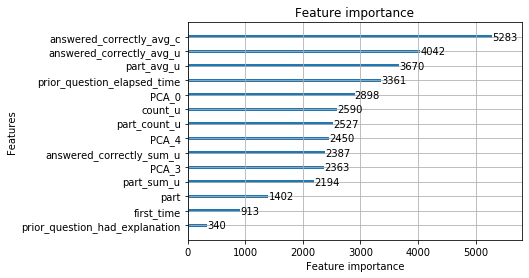

In [12]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=10000,
                    early_stopping_rounds= 300,
                    categorical_feature=['part', 'prior_question_had_explanation']
    
                )
print('auc:', roc_auc_score(y_va, model.predict(valid[FEATS])))
_ = lgb.plot_importance(model)

In [13]:
# tags useful 
# user for each part auc substract all user each part auc
# to do join lectures tags ==> question tags, lecture tags encode
# content_id useful

# optuna


In [14]:
#baseline: 75.84

## add tags6: 

###　valid add with update
##pca
# pca[0,1,2,3,4] : 76.01
# pca[0,1,2]: 75.99
# pca[0,3,4]: 76.00
# pca[0,3,4,5,6]: 76.00
## pca[0,3,4] + part feature: 76.339
## pca[0,3,4] + part feature + timestamp : 76.325

###　valid add without update
## pca[0,3,4] + part feature: 74.57
## pca[0,3,4] + part feature+ timestep_enocde: 74.55
# 74.52 new fea + timestamp




In [15]:
valid

,prior_question_elapsed_time,prior_question_had_explanation,part,PCA_0,PCA_3,PCA_4,answered_correctly_avg_c,answered_correctly_sum_u,count_u,first_time,part_sum_u,part_count_u,answered_correctly_avg_u,part_avg_u
0,24000.0,1,5.0,0.055042,-0.029164,-0.004666,0.491484,60,106,1,45,82,0.566038,0.548780
1,6000.0,1,5.0,0.067818,-0.045371,-0.007527,0.421553,1086,1783,1,350,680,0.609086,0.514706
2,9000.0,1,5.0,0.059213,-0.033641,-0.005436,0.641267,711,1227,0,506,935,0.579462,0.541176
3,25000.0,1,1.0,-0.052956,-0.013092,-0.149354,0.692591,255,618,1,10,17,0.412621,0.588235
4,15000.0,1,5.0,0.055534,-0.029653,-0.004749,0.608436,114,202,1,112,198,0.564356,0.565657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245432,17000.0,1,5.0,0.065576,-0.041680,-0.006851,0.853282,627,993,1,456,712,0.631420,0.640449
245433,27000.0,1,5.0,0.059628,-0.034024,-0.005500,0.854909,211,284,1,77,112,0.742958,0.687500
245434,35800.0,1,7.0,0.095676,-0.119603,-0.022768,0.637363,541,714,1,0,0,0.757703,NaN
245435,35800.0,1,7.0,0.084654,-0.094364,-0.017727,0.703297,541,714,1,0,0,0.757703,NaN


In [16]:
np.mean(ls[-5:])

NameError: name 'ls' is not defined